<a href="https://colab.research.google.com/github/Vats2025/Rice-Classification/blob/Testing/Tabular_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install opendatasets --quiet
import opendatasets as od
od.download("https://www.kaggle.com/datasets/mssmartypants/rice-type-classification")

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: Vatskhushboo
Your Kaggle Key: ··········
Dataset URL: https://www.kaggle.com/datasets/mssmartypants/rice-type-classification


100%|██████████| 888k/888k [00:00<00:00, 741MB/s]

In [ ]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from torch.optim import Adam
from torch.utils.data import Dataset, DataLoader
from torchsummary import summary
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

cuda


In [ ]:
data_df = pd.read_csv("/content/rice-type-classification/riceClassification.csv")
data_df.head()

,id,Area,MajorAxisLength,MinorAxisLength,Eccentricity,ConvexArea,EquivDiameter,Extent,Perimeter,Roundness,AspectRation,Class
0,1,4537,92.229316,64.012769,0.719916,4677,76.004525,0.657536,273.085,0.764510,1.440796,1
1,2,2872,74.691881,51.400454,0.725553,3015,60.471018,0.713009,208.317,0.831658,1.453137,1
2,3,3048,76.293164,52.043491,0.731211,3132,62.296341,0.759153,210.012,0.868434,1.465950,1
3,4,3073,77.033628,51.928487,0.738639,3157,62.551300,0.783529,210.657,0.870203,1.483456,1
4,5,3693,85.124785,56.374021,0.749282,3802,68.571668,0.769375,230.332,0.874743,1.510000,1


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
data_df.dropna(inplace = True)
data_df.drop(["id"], axis = 1, inplace = True)
print("Output Possibilities:", data_df["Class"].unique())
print("Data shape: (row, col)",data_df.shape)


Output Possibilities: [1 0]
Data shape: (row, col) (18185, 11)


In [ ]:
data_df.head()

,Area,MajorAxisLength,MinorAxisLength,Eccentricity,ConvexArea,EquivDiameter,Extent,Perimeter,Roundness,AspectRation,Class
0,4537,92.229316,64.012769,0.719916,4677,76.004525,0.657536,273.085,0.764510,1.440796,1
1,2872,74.691881,51.400454,0.725553,3015,60.471018,0.713009,208.317,0.831658,1.453137,1
2,3048,76.293164,52.043491,0.731211,3132,62.296341,0.759153,210.012,0.868434,1.465950,1
3,3073,77.033628,51.928487,0.738639,3157,62.551300,0.783529,210.657,0.870203,1.483456,1
4,3693,85.124785,56.374021,0.749282,3802,68.571668,0.769375,230.332,0.874743,1.510000,1


###Data Processing

In [ ]:
original_df = data_df.copy()
for column in data_df.columns:
  data_df[column] = data_df[column]/data_df[column].abs().max()
data_df.head()

,Area,MajorAxisLength,MinorAxisLength,Eccentricity,ConvexArea,EquivDiameter,Extent,Perimeter,Roundness,AspectRation,Class
0,0.444368,0.503404,0.775435,0.744658,0.424873,0.666610,0.741661,0.537029,0.844997,0.368316,1.0
1,0.281293,0.407681,0.622653,0.750489,0.273892,0.530370,0.804230,0.409661,0.919215,0.371471,1.0
2,0.298531,0.416421,0.630442,0.756341,0.284520,0.546380,0.856278,0.412994,0.959862,0.374747,1.0
3,0.300979,0.420463,0.629049,0.764024,0.286791,0.548616,0.883772,0.414262,0.961818,0.379222,1.0
4,0.361704,0.464626,0.682901,0.775033,0.345385,0.601418,0.867808,0.452954,0.966836,0.386007,1.0


###Data Splitting

In [ ]:
X = np.array(data_df.iloc[:,:-1])
Y = np.array(data_df.iloc[:,-1]).reshape(-1) # Explicitly reshape labels to 1D

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size = 0.3)
x_test, x_val, y_test, y_val = train_test_split(x_test, y_test, test_size=0.5)

In [ ]:
print(x_train.shape)
print(x_val.shape)
print(x_test.shape)

(12729, 10)
(2728, 10)
(2728, 10)


In [ ]:
print("Training set is:", x_train.shape[0], "rows which is:", round(x_train.shape[0]/data_df.shape[0],4)*100, "%")
print("Validating set is:", x_val.shape[0], "rows which is:", round(x_val.shape[0]/data_df.shape[0],4)*100, "%")
print("Testing set is:", x_val.shape[0], "rows which is:", round(x_test.shape[0]/data_df.shape[0],4)*100, "%")

Training set is: 12729 rows which is: 70.0 %
Validating set is: 2728 rows which is: 15.0 %
Testing set is: 2728 rows which is: 15.0 %


###Dataset Object

In [ ]:
class dataset(Dataset):
  def __init__(self, X, Y):
    self.X = torch.tensor(X, dtype = torch.float32).to(device)
    self.Y = torch.tensor(Y, dtype = torch.float32).to(device)

  def __len__(self):
    return len(self.X)

  def __getitem__(self, index):
    return self.X[index], self.Y[index]

In [ ]:
training_data = dataset(x_train, y_train)
validation_data = dataset(x_val, y_val)
testing_data = dataset(x_test, y_test)

###Training Hyperparameters

In [ ]:
BATCH_SIZE = 8
EPOCHS = 10
HIDDEN_NEURONS = 10
LR = 1e-3

###Data Loader

In [ ]:
train_dataloader = DataLoader(training_data, batch_size = BATCH_SIZE, shuffle=True)
validation_dataloader = DataLoader(validation_data, batch_size=BATCH_SIZE, shuffle=True)
test_dataloader = DataLoader(testing_data, batch_size=BATCH_SIZE, shuffle=True)

In [ ]:
for x, y in train_dataloader:
  print(x)
  print("=====")
  print(y)
  break

tensor([[0.8462, 0.8504, 0.8641, 0.9196, 0.8026, 0.9199, 0.7206, 0.7294, 0.8724,
         0.5583],
        [0.7707, 0.7717, 0.8769, 0.8885, 0.7384, 0.8779, 0.7094, 0.6911, 0.8850,
         0.4993],
        [0.6735, 0.8908, 0.6589, 0.9752, 0.6395, 0.8206, 0.6375, 0.7155, 0.7214,
         0.7670],
        [0.5678, 0.7983, 0.6223, 0.9685, 0.5441, 0.7535, 0.8957, 0.6546, 0.7267,
         0.7278],
        [0.8610, 0.8740, 0.8640, 0.9261, 0.8270, 0.9279, 0.7122, 0.7575, 0.8229,
         0.5739],
        [0.9079, 0.8736, 0.9053, 0.9147, 0.8636, 0.9529, 0.6723, 0.7562, 0.8707,
         0.5475],
        [0.8780, 0.8689, 0.8789, 0.9207, 0.8324, 0.9370, 0.6491, 0.7470, 0.8628,
         0.5609],
        [0.5457, 0.7773, 0.6157, 0.9663, 0.5216, 0.7387, 0.6847, 0.6322, 0.7489,
         0.7163]], device='cuda:0')
=====
tensor([0., 0., 1., 1., 0., 0., 0., 1.], device='cuda:0')


###Model class


In [ ]:
class MyModel(nn.Module):
  def __init__(self):
    super(MyModel, self).__init__()
    self.input_layer = nn.Linear(X.shape[1], HIDDEN_NEURONS)
    self.Linear = nn.Linear(HIDDEN_NEURONS, 1)
    self.sigmoid = nn.Sigmoid()
#how data flows inside the model
  def forward(self, x):
    x = self.input_layer(x)
    x = self.Linear(x)
    x = self.sigmoid(x)
    return x

###Model Creation

In [ ]:
model = MyModel().to(device)
summary(model, (X.shape[1],))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                   [-1, 10]             110
            Linear-2                    [-1, 1]              11
           Sigmoid-3                    [-1, 1]               0
Total params: 121
Trainable params: 121
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.00
Estimated Total Size (MB): 0.00
----------------------------------------------------------------


###Loss and optimizer

In [ ]:
criterion = nn.BCELoss()
optimizer = Adam(model.parameters(), lr = LR)

###Validation

In [ ]:
total_loss_train_plot = []
total_loss_validation_plot = []
total_acc_train_plot = []
total_acc_validation_plot = []

for epoch in range(EPOCHS):
    total_acc_train = 0
    total_loss_train = 0
    total_acc_val = 0
    total_loss_val = 0
    ## Training 3+
    for data in train_dataloader:

        inputs, labels = data

        prediction = model(inputs).squeeze(1)

        batch_loss = criterion(prediction, labels)

        total_loss_train += batch_loss.item()

        acc = ((prediction).round() == labels).sum().item()

        total_acc_train += acc
#till now we are done with propogation
        batch_loss.backward() #backward propogation
        optimizer.step()
        optimizer.zero_grad()

    ## Validation
    with torch.no_grad():#using pytorch only for testing not for training
        for data in validation_dataloader:
            inputs, labels = data

            prediction = model(inputs).squeeze(1)

            batch_loss = criterion(prediction, labels)

            total_loss_val += batch_loss.item()

            acc = ((prediction).round() == labels).sum().item()

            total_acc_val += acc
    total_loss_train_plot.append(round(total_loss_train/1000, 4))
    total_loss_validation_plot.append(round(total_loss_val/1000, 4))

    total_acc_train_plot.append(round(total_acc_train/(training_data.__len__())*100, 4))
    total_acc_validation_plot.append(round(total_acc_val/(validation_data.__len__())*100, 4))

    print(f'''Epoch no. {epoch + 1} Train Loss: {round(total_loss_train/1000, 4)} Train Accuracy: {round(total_acc_train/(training_data.__len__())*100, 4)}
              Validation Loss: {round(total_loss_val/1000, 4)} Validation Accuracy: {round(total_acc_val/(validation_data.__len__())*100, 4)}''')
    print("="*50)


Epoch no. 1 Train Loss: 0.6079 Train Accuracy: 90.5491
              Validation Loss: 0.0432 Validation Accuracy: 97.8739
Epoch no. 2 Train Loss: 0.1241 Train Accuracy: 98.5466
              Validation Loss: 0.0218 Validation Accuracy: 98.0938
Epoch no. 3 Train Loss: 0.0794 Train Accuracy: 98.6173
              Validation Loss: 0.018 Validation Accuracy: 98.2405
Epoch no. 4 Train Loss: 0.0677 Train Accuracy: 98.7273
              Validation Loss: 0.017 Validation Accuracy: 98.1305
Epoch no. 5 Train Loss: 0.0641 Train Accuracy: 98.6016
              Validation Loss: 0.0173 Validation Accuracy: 98.0572
Epoch no. 6 Train Loss: 0.0638 Train Accuracy: 98.7509
              Validation Loss: 0.0166 Validation Accuracy: 98.1672
Epoch no. 7 Train Loss: 0.063 Train Accuracy: 98.7116
              Validation Loss: 0.0167 Validation Accuracy: 98.1672
Epoch no. 8 Train Loss: 0.0626 Train Accuracy: 98.7273
              Validation Loss: 0.017 Validation Accuracy: 98.1672
Epoch no. 9 Train Loss: 0.06

###Testing

In [ ]:
with torch.no_grad():
  total_loss_test = 0
  total_acc_test = 0
  for data in test_dataloader:
    inputs, labels = data

    prediction = model(inputs).squeeze(1)

    batch_loss_test = criterion(prediction, labels)

    total_loss_test += batch_loss_test.item()

    acc = ((prediction).round() == labels).sum().item()

    total_acc_test += acc

print(f'''Accuracy: {round(total_acc_test/(testing_data.__len__())*100, 4)}''')


Accuracy: 98.7903


###Plotting and Visualizations

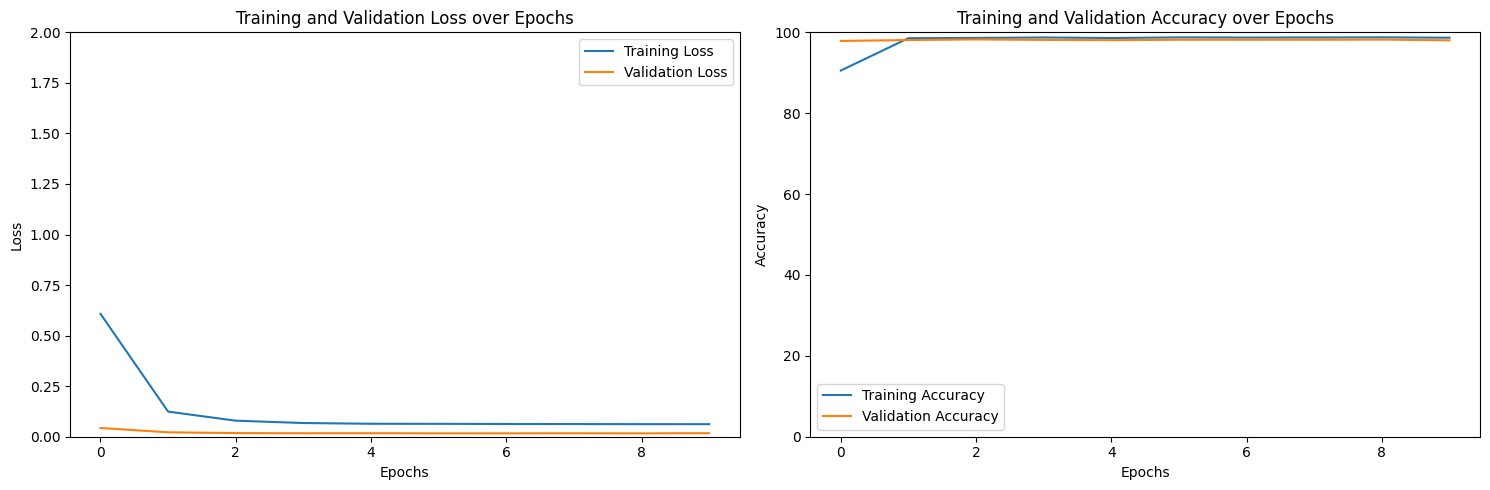

In [ ]:
fig, axs = plt.subplots(nrows = 1, ncols = 2, figsize = (15,5))

axs[0].plot(total_loss_train_plot, label='Training Loss')
axs[0].plot(total_loss_validation_plot, label='Validation Loss')
axs[0].set_title('Training and Validation Loss over Epochs')
axs[0].set_xlabel('Epochs')
axs[0].set_ylabel('Loss')
axs[0].set_ylim([0, 2])
axs[0].legend()

axs[1].plot(total_acc_train_plot, label='Training Accuracy')
axs[1].plot(total_acc_validation_plot, label='Validation Accuracy')
axs[1].set_title('Training and Validation Accuracy over Epochs')
axs[1].set_xlabel('Epochs')
axs[1].set_ylabel('Accuracy')
axs[1].set_ylim([0, 100])
axs[1].legend()

plt.tight_layout()

plt.show()

###Inference

In [ ]:
area = float(input("Area: "))/original_df['Area'].abs().max()
MajorAxisLength = float(input("Major Axis Length: "))/original_df['MajorAxisLength'].abs().max()
MinorAxisLength = float(input("Minor Axis Length: "))/original_df['MinorAxisLength'].abs().max()
Eccentricity = float(input("Eccentricity: "))/original_df['Eccentricity'].abs().max()
ConvexArea = float(input("Convex Area: "))/original_df['ConvexArea'].abs().max()
EquivDiameter = float(input("EquivDiameter: "))/original_df['EquivDiameter'].abs().max()
Extent = float(input("Extent: "))/original_df['Extent'].abs().max()
Perimeter = float(input("Perimeter: "))/original_df['Perimeter'].abs().max()
Roundness = float(input("Roundness: "))/original_df['Roundness'].abs().max()
AspectRation = float(input("AspectRation: "))/original_df['AspectRation'].abs().max()

my_inputs = [area, MajorAxisLength, MinorAxisLength, Eccentricity, ConvexArea, EquivDiameter, Extent, Perimeter, Roundness, AspectRation]

print("="*20)
model_inputs = torch.Tensor(my_inputs).to(device)
prediction = (model(model_inputs))
print(prediction)
print("Class is: ", round(prediction.item()))